In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch import optim

In [4]:
raw_df = pd.read_csv('AMZN.csv')
raw_df['Date'] = pd.to_datetime(raw_df['Date'])
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6257 entries, 0 to 6256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6257 non-null   datetime64[ns]
 1   Open       6257 non-null   float64       
 2   High       6257 non-null   float64       
 3   Low        6257 non-null   float64       
 4   Close      6257 non-null   float64       
 5   Adj Close  6257 non-null   float64       
 6   Volume     6257 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 342.3 KB


In [123]:
train_df = raw_df[raw_df['Date'] < '2019-01-01']
val_df = raw_df[(raw_df['Date'] >= '2019-01-01') & (raw_df['Date'] < '2021-01-01')]
test_df = raw_df[(raw_df['Date'] >= '2021-01-01')]

#High Data
train_price_df = train_df[['High']]
val_price_df = val_df[['High']]
test_price_df = test_df[['High']]

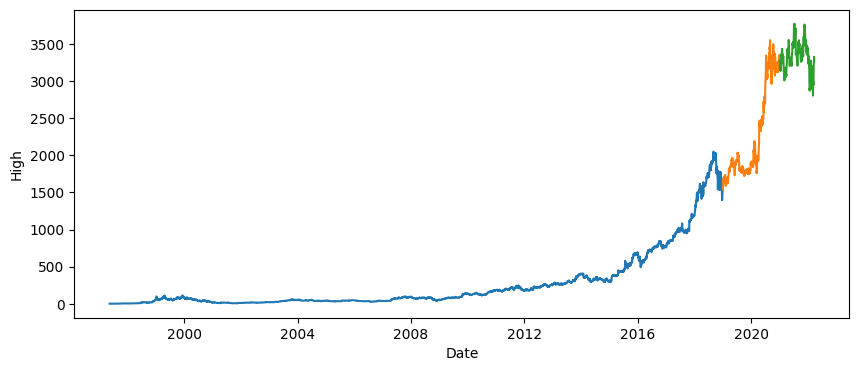

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.lineplot(data=train_df, x='Date', y='High')
sns.lineplot(data=val_df, x='Date', y='High')
sns.lineplot(data=test_df, x='Date', y='High');

In [124]:
sc = MinMaxScaler()
train_price_df = sc.fit_transform(train_price_df)
val_price_df = sc.fit_transform(val_price_df)
test_price_df = sc.fit_transform(test_price_df)

In [125]:
print(train_price_df.shape, val_price_df.shape, test_price_df.shape)

(5443, 1) (505, 1) (309, 1)


In [9]:
def transform_data(stock, lookback):
    data_raw = stock
    data = []
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    
    x_train = data[:,:-1,:]
    y_train = data[:,-1,:]
    
    
    return [x_train, y_train]

In [126]:
num_hidden = 60
x_train, y_train = transform_data(train_price_df, num_hidden)
x_val, y_val = transform_data(val_price_df, num_hidden)
x_test, y_test = transform_data(test_price_df, num_hidden)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)

x_train.shape =  (5383, 59, 1)
y_train.shape =  (5383, 1)


In [127]:
x_train_tensor = torch.from_numpy(x_train).type(torch.Tensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.Tensor)

x_val_tensor = torch.from_numpy(x_val).type(torch.Tensor)
y_val_tensor= torch.from_numpy(y_val).type(torch.Tensor)

x_test_tensor = torch.from_numpy(x_test).type(torch.Tensor)
y_test_tensor= torch.from_numpy(y_test).type(torch.Tensor)

In [12]:
class LSTM(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers):
        super(LSTM, self).__init__()
        self.hidden_dim = num_hiddens
        self.num_layers = num_layers

        self.lstm = nn.LSTM(num_inputs, num_hiddens, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(num_hiddens, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [13]:
model = LSTM(1, 32, 2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [14]:
for epoch in range(50):
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{50}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.039701
Epoch [2/50], Loss: 0.049669
Epoch [3/50], Loss: 0.034118
Epoch [4/50], Loss: 0.036699
Epoch [5/50], Loss: 0.037596
Epoch [6/50], Loss: 0.033616
Epoch [7/50], Loss: 0.027749
Epoch [8/50], Loss: 0.022339
Epoch [9/50], Loss: 0.019584
Epoch [10/50], Loss: 0.014608
Epoch [11/50], Loss: 0.003588
Epoch [12/50], Loss: 0.002475
Epoch [13/50], Loss: 0.009093
Epoch [14/50], Loss: 0.009025
Epoch [15/50], Loss: 0.005183
Epoch [16/50], Loss: 0.002274
Epoch [17/50], Loss: 0.001432
Epoch [18/50], Loss: 0.002127
Epoch [19/50], Loss: 0.003240
Epoch [20/50], Loss: 0.003859
Epoch [21/50], Loss: 0.003707
Epoch [22/50], Loss: 0.002976
Epoch [23/50], Loss: 0.002073
Epoch [24/50], Loss: 0.001394
Epoch [25/50], Loss: 0.001136
Epoch [26/50], Loss: 0.001271
Epoch [27/50], Loss: 0.001603
Epoch [28/50], Loss: 0.001860
Epoch [29/50], Loss: 0.001858
Epoch [30/50], Loss: 0.001589
Epoch [31/50], Loss: 0.001173
Epoch [32/50], Loss: 0.000796
Epoch [33/50], Loss: 0.000607
Epoch [34/50], Loss

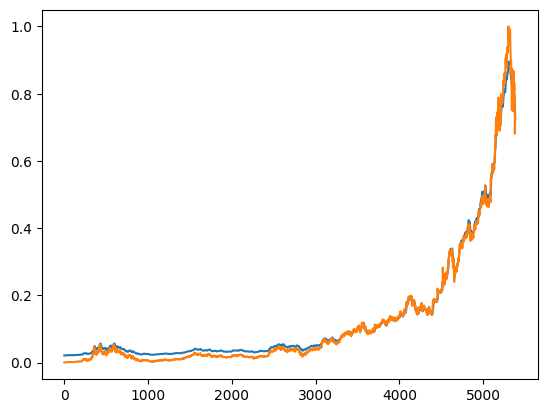

In [15]:
train_preds = model(x_train_tensor).detach().numpy()
plt.plot(train_preds)
plt.plot(y_train);

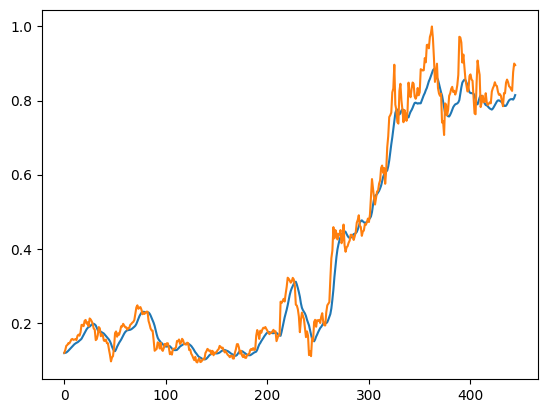

In [16]:
y_preds = model(x_val_tensor).detach().numpy()
plt.plot(y_preds)
plt.plot(y_val);

In [106]:
def predict(day: int = 0, predict_days: int = 50) -> np.array:
    x = torch.unsqueeze(x_val_tensor[day], dim=0)
    y_preds = []
    for _ in range(predict_days):
        y_pred = model(x)
        y_preds.append(y_pred.detach().numpy())
        
        x = torch.cat((x[:, 1:, :], y_pred.unsqueeze(1)), dim=1)

    y_preds_combined = np.squeeze(y_preds)

    return y_preds_combined

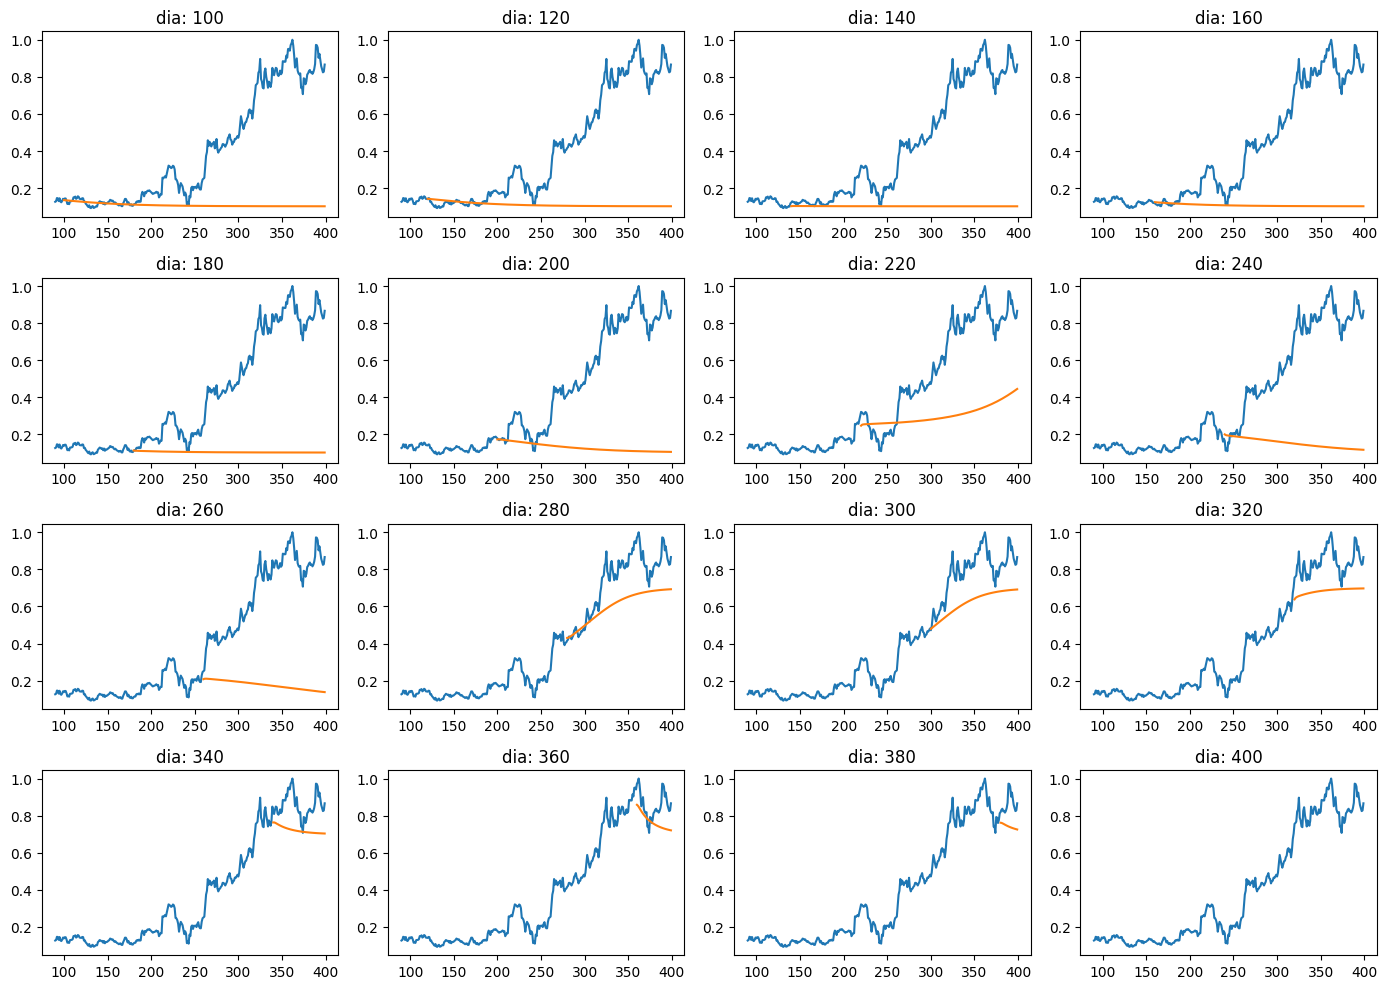

In [122]:
dia_a_predecir = 100
dias_a_predecir = 300
iterx = 20

fig, ax = plt.subplots(4, 4, figsize=(14, 10))
for _ in range(16):
    i = _ // 4
    j = _ % 4

    dia = dia_a_predecir + iterx * _
    predict_days = dias_a_predecir - iterx * _
    y0 = predict(dia, predict_days)

    sns.lineplot(x=np.arange(dia_a_predecir - 10, dia_a_predecir + dias_a_predecir), y=np.squeeze(y_val[dia_a_predecir-10:dia_a_predecir+dias_a_predecir]), legend=False, ax=ax[i, j])
    sns.lineplot(x=np.arange(dia, dia + predict_days), y=y0, label='Predictions', legend=False, ax=ax[i, j])

    ax[i, j].set_title(f"dia: {dia}")

plt.tight_layout()
plt.show()

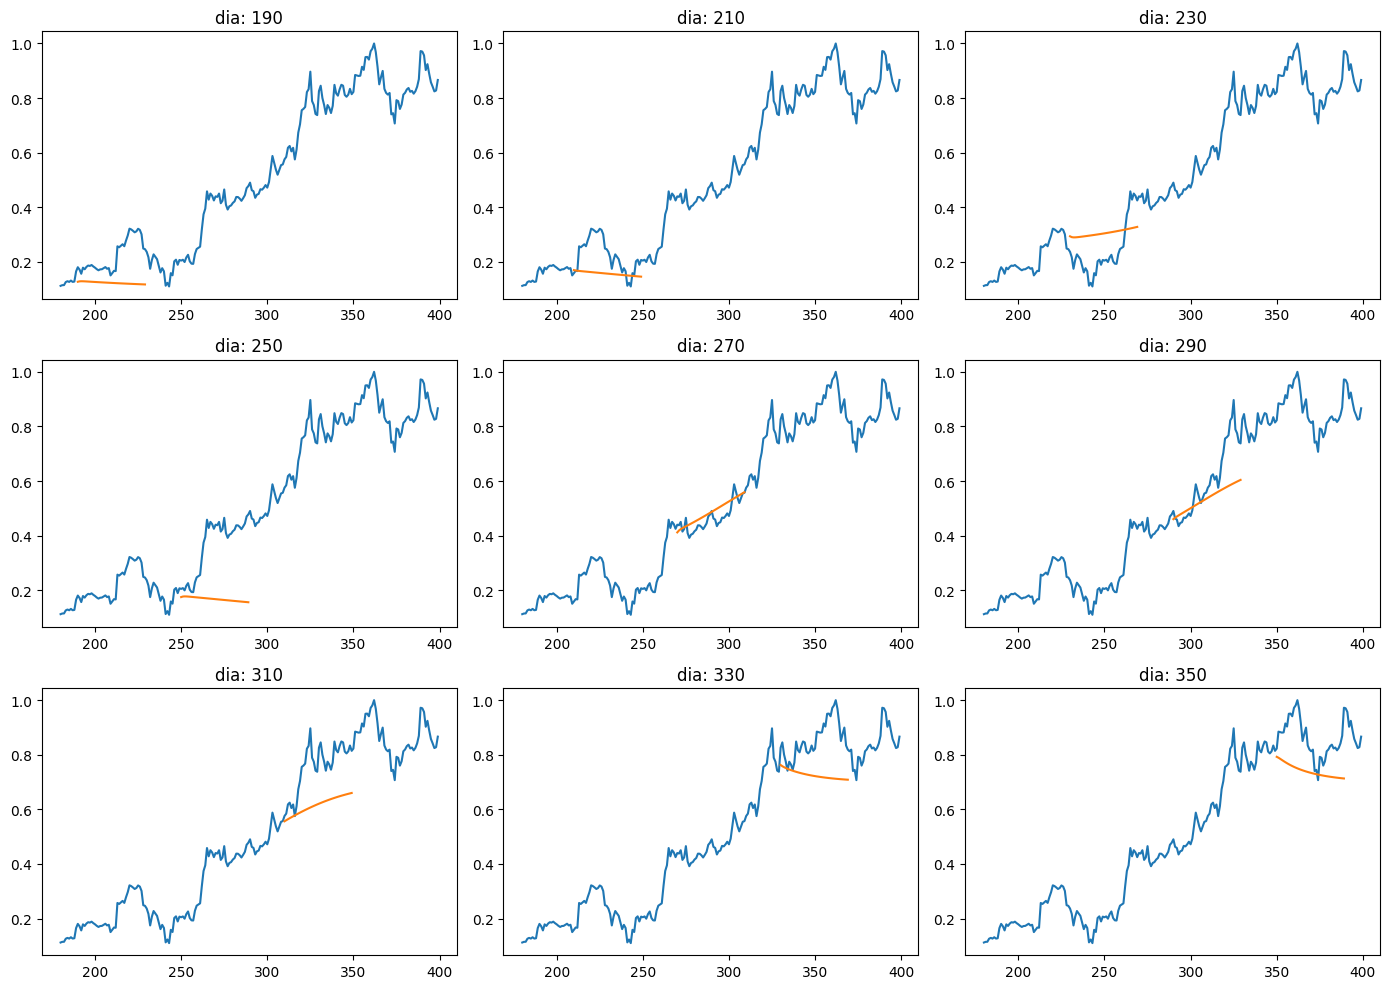

In [129]:
dia_a_predecir = 190
dias_a_predecir = 200
iterx = 20

fig, ax = plt.subplots(3, 3, figsize=(14, 10))
for _ in range(9):
    i = _ // 3
    j = _ % 3

    dia = dia_a_predecir + iterx * _
    predict_days = dias_a_predecir - iterx * _
    y0 = predict(dia, predict_days)

    sns.lineplot(x=np.arange(dia_a_predecir - 10, dia_a_predecir + dias_a_predecir + 10), y=np.squeeze(y_val[dia_a_predecir-10:dia_a_predecir+dias_a_predecir+10]), legend=False, ax=ax[i, j])
    sns.lineplot(x=np.arange(dia, dia + predict_days)[:40], y=y0[:40], label='Predictions', legend=False, ax=ax[i, j])

    ax[i, j].set_title(f"dia: {dia}")

plt.tight_layout()
plt.show()

In [ ]:
dia_a_predecir = 190
dias_a_predecir = 200
iterx = 20

fig, ax = plt.subplots(3, 3, figsize=(14, 10))
for _ in range(9):
    i = _ // 3
    j = _ % 3

    dia = dia_a_predecir + iterx * _
    predict_days = dias_a_predecir - iterx * _
    y0 = predict(dia, predict_days)

    sns.lineplot(x=np.arange(dia_a_predecir - 10, dia_a_predecir + dias_a_predecir + 10), y=np.squeeze(y_val[dia_a_predecir-10:dia_a_predecir+dias_a_predecir+10]), legend=False, ax=ax[i, j])
    sns.lineplot(x=np.arange(dia, dia + predict_days), y=y0, label='Predictions', legend=False, ax=ax[i, j])

    ax[i, j].set_title(f"dia: {dia}")

plt.tight_layout()
plt.show()

In [ ]:
def transform_data(stock, lookback):
    data_raw = stock
    data = []
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    
    x_train = data[:,:-1,:]
    y_train = data[:,-1,:]
    
    
    return [x_train, y_train]